In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import librosa
import librosa.display

import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import os

# 데이터 준비

In [ ]:
!git clone https://github.com/siddiquelatif/URDU-Dataset.git

Cloning into 'URDU-Dataset'...
remote: Enumerating objects: 442, done.
remote: Total 442 (delta 0), reused 0 (delta 0), pack-reused 442
Receiving objects: 100% (442/442), 72.05 MiB | 29.67 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
labels = {
    'Angry':0,
    'Happy':1,
    'Neutral':2,
    'Sad':3
}

In [ ]:
os.path.basename('/root/asdf/qwer/ttt.json')

'ttt.json'

In [ ]:
data = []
for root, dirs, filenames in os.walk('URDU-Dataset'):
    #ex) base = 'Angry'
    base = os.path.basename(root)
    if base not in labels:
        continue
    label = labels[base] #ex) label = 0
    for filename in filenames:
        first, last = os.path.splitext(filename)
        if last != '.wav':
            continue
        path = os.path.join(root, filename)
        data.append((path, label))

In [ ]:
data

In [ ]:
n_mfcc = 13
batch_size = 16
sr = 11025
duration = 3
max_len = int(sr * duration)

# 음성 데이터 불러오기

In [ ]:
data[190]

('URDU-Dataset/Happy/SM17_F2_H048.wav', 1)

In [ ]:
Xf, sample_ratef = librosa.load(data[190][0],
                                res_type='kaiser_fast', sr=sr)

In [ ]:
sample_ratef

11025

In [ ]:
len(Xf)

22050

In [ ]:
ipd.Audio(Xf, rate=sr)

In [ ]:
t = np.linspace(0, 1, sr)
1000
x = 0.5 * np.sin(t * np.pi * 2 * 1000)
x += 0.3 * np.sin(t * np.pi * 2 * 2000)
x += 0.2 * np.sin(t * np.pi * 2 * 500)
ipd.Audio(x, rate=sr / 2)

array([ 0.        ,  0.26979713,  0.45429801,  0.49517274,  0.37949879,
        0.14384645, -0.13728289, -0.3750103 , -0.49417835, -0.4571121 ,
       -0.27553003, -0.00683925,  0.26401376,  0.45139891,  0.49607448,
        0.38391628,  0.1503831 , -0.13069364, -0.37045164, -0.49309149])

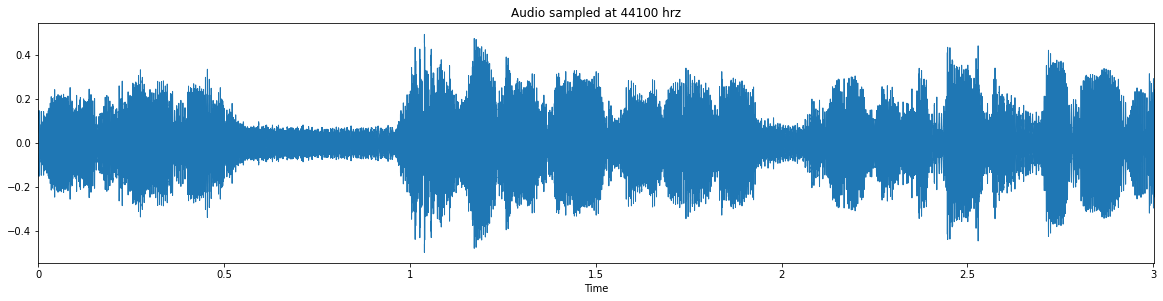

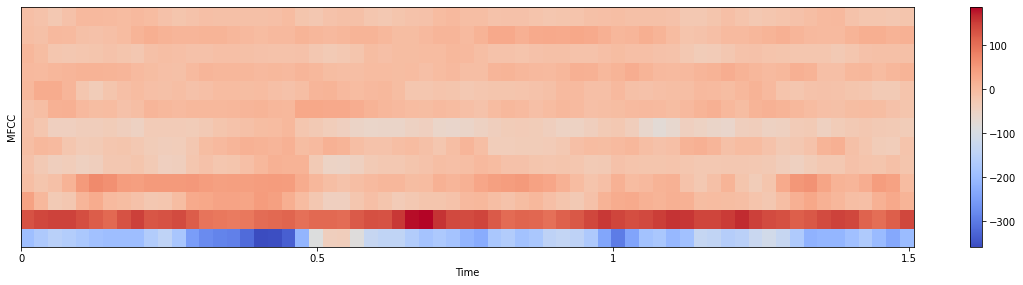

In [ ]:
Xf, sample_ratef = librosa.load(data[190][0],
                                res_type='kaiser_fast', sr=sr)
mfcc = librosa.feature.mfcc(y=Xf, sr=sample_ratef, n_mfcc=n_mfcc)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(Xf, sr=sample_ratef)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(Xf, rate=sample_ratef)


In [ ]:
mfcc.shape

(13, 65)

In [ ]:
mfcc.shape

(13, 44)

# 프리프로세싱

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


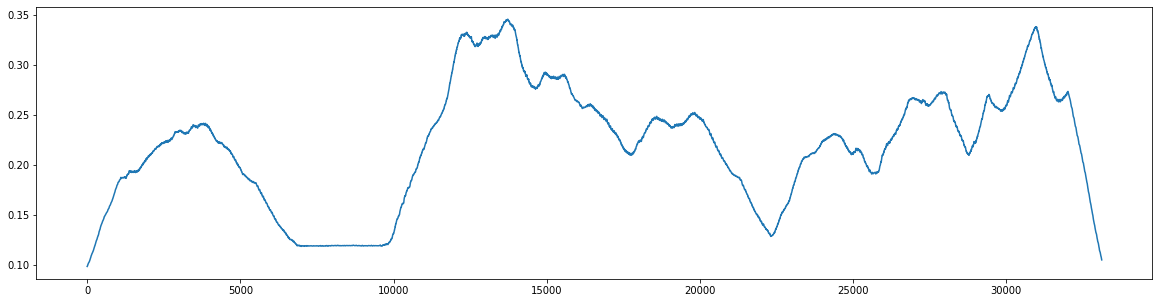

In [ ]:
mask_size = int(sr * 0.2) # 0.2초
mask = np.ones(mask_size) / mask_size
filter = mask[..., None, None]
Xf = Xf / max(Xf)
conv = tf.nn.conv1d(abs(Xf[None, :, None]).astype(np.float), filter, stride=1, padding='SAME')
conv = conv.numpy().reshape(-1)
# conv = np.convolve(abs(Xf), mask)
plt.figure(figsize=(20, 5))
plt.plot(conv)

27343 33114


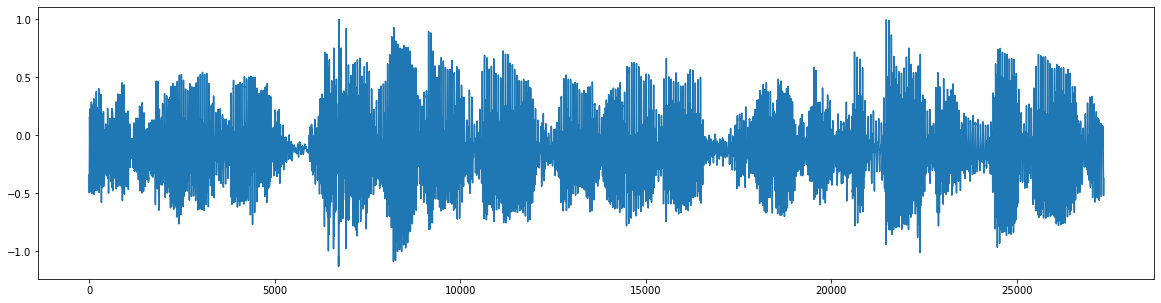

In [ ]:
filtered = Xf[conv > 0.15]
plt.figure(figsize=(20, 5))
plt.plot(filtered)
print(len(filtered), len(Xf))
ipd.Audio(filtered, rate=sr)

In [ ]:
a = np.array([1, 2, 3, 4, 5])
a[-7:]

array([1, 2, 3, 4, 5])

In [ ]:
shorten = filtered[-max_len:]
if len(shorten) < max_len:
    shorten = np.concatenate([np.zeros(max_len - len(shorten)), shorten])

ipd.Audio(shorten, rate=sr)

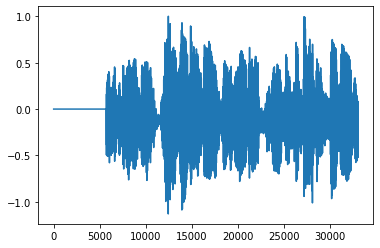

In [ ]:
plt.plot(shorten)

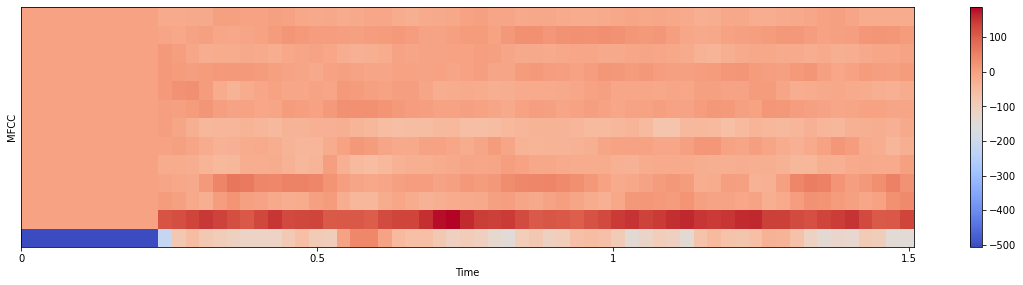

In [ ]:
mfcc = librosa.feature.mfcc(y=shorten, sr=sample_ratef, n_mfcc=n_mfcc)
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
mfcc.shape

(13, 65)

In [ ]:
data_x = []
data_y = []
count = 0

for file_path, label in data:
    Xf, sample_ratef = librosa.load(file_path,
                                res_type='kaiser_fast',sr=sr)
    Xf = Xf / max(Xf)
    conv = tf.nn.conv1d(abs(Xf[None, :, None]).astype(np.float), filter, stride=1, padding='SAME')
    conv = conv.numpy().reshape(-1)
    filtered = Xf[conv > 0.01]
    shorten = filtered[-max_len:]
    if len(shorten) < max_len:
        shorten = np.concatenate([np.zeros(max_len - len(shorten)), shorten])
    mfcc = librosa.feature.mfcc(y=shorten, sr=sample_ratef, n_mfcc=n_mfcc)
    data_x.append(mfcc)
    data_y.append(label)
    print('\r' + str(count), end='')
    count += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


399

In [ ]:
data_x = np.array(data_x)
data_y = np.array(data_y)

data_x = data_x.astype(np.float32)
data_x = data_x.transpose([0, 2, 1])

In [ ]:
data_x.shape

(400, 65, 13)

In [ ]:
data_y

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

# 데이터셋 준비

In [ ]:
random_index = np.random.permutation(len(data_x))
train_x = data_x[random_index[:300]]
train_y = data_y[random_index[:300]]
valid_x = data_x[random_index[300:]]
valid_y = data_y[random_index[300:]]

dataset_train = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset_valid = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

In [ ]:
dt = dataset_train.cache().repeat().shuffle(100).batch(batch_size).prefetch(1)
dv = dataset_valid.cache().batch(batch_size).prefetch(1)
[i[0].shape for i in dt.take(10)]

[TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13])]

# 모델 생성 및 학습

In [ ]:
train_x.shape

(300, 65, 13)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Input(data_x.shape[1:]),
    keras.layers.Reshape([-1, n_mfcc, 1]),
    keras.layers.Conv2D(16, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(32, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(64, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(64, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Reshape([-1, n_mfcc * 64]),
    keras.layers.LSTM(n_mfcc * 64, return_sequences=True),
    keras.layers.LSTM(n_mfcc * 64, return_sequences=True),
    keras.layers.LSTM(n_mfcc * 64),
    keras.layers.Dense(4, activation='softmax'),
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 65, 13, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 65, 13, 16)        144       
                                                                 
 batch_normalization (BatchN  (None, 65, 13, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 65, 13, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 13, 32)        4608      
                                                                 
 batch_normalization_1 (Batc  (None, 65, 13, 32)       128       
 hNormalization)                                        

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [ ]:
steps = (300 // batch_size)
cb_es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(dt, epochs=100, steps_per_epoch=steps, validation_data=dv,
                    batch_size=batch_size, callbacks=[cb_es])

Epoch 1/100
18/18 [==============================] - 10s 96ms/step - loss: 1.9683 - accuracy: 0.3681 - val_loss: 1.4170 - val_accuracy: 0.3900
Epoch 2/100
18/18 [==============================] - 0s 23ms/step - loss: 1.4289 - accuracy: 0.3785 - val_loss: 1.4366 - val_accuracy: 0.2200
Epoch 3/100
18/18 [==============================] - 0s 23ms/step - loss: 1.0064 - accuracy: 0.5833 - val_loss: 1.0219 - val_accuracy: 0.5400
Epoch 4/100
18/18 [==============================] - 0s 23ms/step - loss: 0.9332 - accuracy: 0.6146 - val_loss: 1.0699 - val_accuracy: 0.5500
Epoch 5/100
18/18 [==============================] - 0s 23ms/step - loss: 0.8637 - accuracy: 0.6354 - val_loss: 1.0716 - val_accuracy: 0.5000
Epoch 6/100
18/18 [==============================] - 0s 23ms/step - loss: 0.7442 - accuracy: 0.6806 - val_loss: 0.8563 - val_accuracy: 0.6200
Epoch 7/100
18/18 [==============================] - 0s 23ms/step - loss: 0.6885 - accuracy: 0.7500 - val_loss: 0.8387 - val_accuracy: 0.6700
Epoch

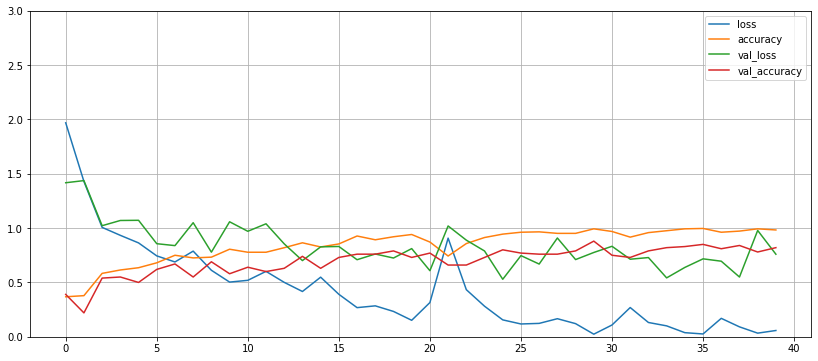

In [ ]:
pd.DataFrame(history.history).plot(figsize=(14, 6))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

# 분석

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = valid_y
y_prob = model.predict(valid_x)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_true, y_pred)
cm

array([[18,  2,  0,  0],
       [ 0, 20,  6,  0],
       [ 0,  1, 21,  0],
       [ 0,  2,  7, 23]])

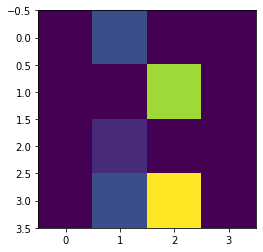

In [ ]:
s = cm.sum(axis=1)
cm = cm / s
np.fill_diagonal(cm, 0)
plt.imshow(cm)